# 1. initial Setup and Imports

In [ ]:
#import numpy for number array handling and represent rgb image pixel values
import numpy as np

#import tensorflow to use any tools needed for deep learning
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import libraries for visualization of data
import matplotlib.pyplot as plt

#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline

from PIL import Image
from keras.preprocessing import image
from keras.utils import load_img
from keras.utils import img_to_array
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.utils.vis_utils import plot_model

In [ ]:
# !pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown 1nRp-jWL5qgih064-j2xfD8QYN3gd5XNn

Downloading...
From: https://drive.google.com/uc?id=1nRp-jWL5qgih064-j2xfD8QYN3gd5XNn
To: /content/endek-dataset-revisi-skripsi.zip
100% 155M/155M [00:00<00:00, 209MB/s]


In [ ]:
! unzip -q "/content/endek-dataset-revisi-skripsi.zip"

# 2. Load and Split images along with applying Data Preprocessing and Data Augmentation

In [ ]:
data_path = '/content/Endek Dataset'
valid_path = '/content/Endek Dataset'
test_path = '/content/Endek Dataset/Testing'

train_datagen = ImageDataGenerator(
    # rescale=1./255,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=10,
    rotation_range=90,
    validation_split=0.2)


train_batches = train_datagen.flow_from_directory(
    directory=data_path, target_size=(224,224), classes=['Endek Corak Cakra',
                                                          'Endek Corak Cemara',
                                                          'Endek Corak Cempaka',
                                                          'Endek Corak Cepuk',
                                                          'Endek Corak Lubeng',
                                                          'Endek Corak Rangrang',
                                                          'Endek Corak Uang Kepeng',
                                                         'Unknown'], batch_size=8, subset='training', shuffle=True)

valid_batches = train_datagen.flow_from_directory(
    directory=valid_path, target_size=(224,224), classes=['Endek Corak Cakra',
                                                          'Endek Corak Cemara',
                                                          'Endek Corak Cempaka',
                                                          'Endek Corak Cepuk',
                                                          'Endek Corak Lubeng',
                                                          'Endek Corak Rangrang',
                                                          'Endek Corak Uang Kepeng',
                                                          'Unknown'], batch_size=8, subset='validation', shuffle=True)

test_batches = train_datagen.flow_from_directory(
    directory=test_path, target_size=(224,224), classes=['Endek Corak Cakra',
                                                          'Endek Corak Cemara',
                                                          'Endek Corak Cempaka',
                                                          'Endek Corak Cepuk',
                                                          'Endek Corak Lubeng',
                                                          'Endek Corak Rangrang',
                                                          'Endek Corak Uang Kepeng',
                                                         'Unknown'], batch_size=8, shuffle=False)

Found 192 images belonging to 8 classes.
Found 47 images belonging to 8 classes.
Found 40 images belonging to 8 classes.


# 3. Visualization of the images after Preprocessing

In [ ]:
# plot images after applying VGG16 data preprocessing method
def plotImages(images):
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

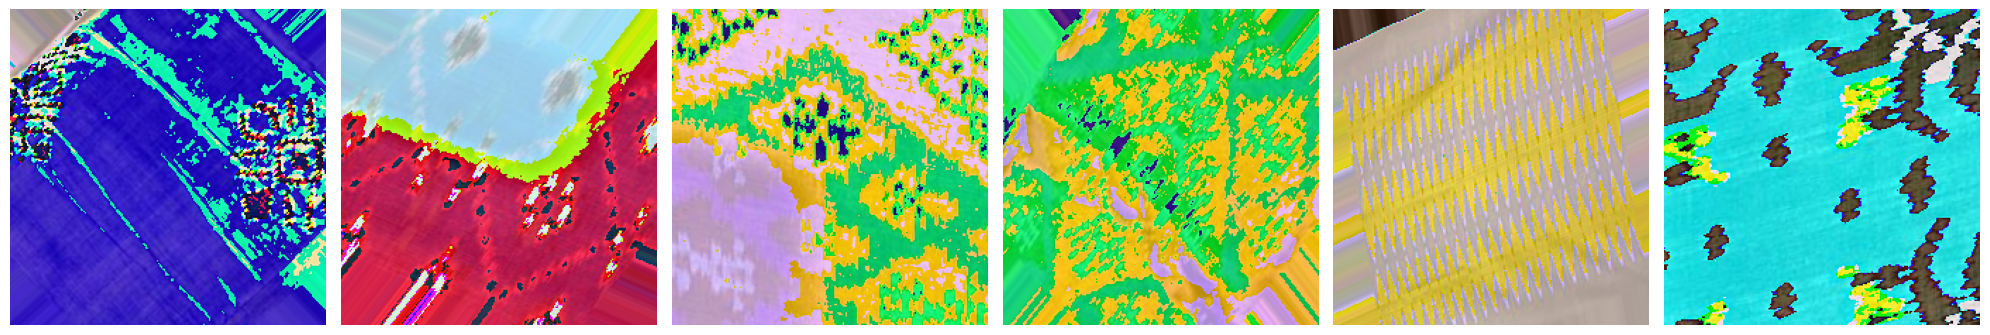

In [ ]:
imgs, labels = next(train_batches)
plotImages(imgs)

# 4. Building CNN Architecture

In [ ]:
# set the input image size for proposed CNN model
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# import the convolution base of the VGG16 model with pre-trained weights
base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet')

4334752/4334752 [==============================] - 1s 0us/step


In [ ]:
# summary of convolution base of VGG16 model
# base_model.summary()
# plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Initialize a sequential model to group a linear stack of layers
model = Sequential()

# Freeze the convolutional base of VGG16 to prevent the pre-trained weights being updated
# during training inorder to extract features
base_model.trainable=False

# add VGG16 convolution base to initialize sequential model
model.add(base_model)

# add global average pooling layer
model.add(GlobalAveragePooling2D())

# add densely-connected NN layer with 512 hidden units
model.add(Dense(units=512, activation='relu'))  # use ReLU activation function
model.add(BatchNormalization())                 # normalize and scale inputs or activations
model.add(Dropout(0.2))                         # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 128 hidden units
model.add(Dense(units=128, activation='relu')) # use ReLU activation function
model.add(BatchNormalization())                # normalize and scale inputs or activations
model.add(Dropout(0.2))                        # applies dopout to the input which will randomly disable 20% of hidden units

# add densely-connected NN layer with 5 hidden units
model.add(Dense(units=8, activation='softmax')) # use Softmax activation function to do final predictions

In [ ]:
# summary of proposed CNN model(architecture)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               295424    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

# 5. Compile the Built CNN Model

In [ ]:
# compile the built CNN model by selecting suitable optimizer and loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Train the CNN model

In [ ]:
# train the model with appropriate number of epochs
model_details = model.fit(x=train_batches, validation_data=valid_batches, epochs=10)

Epoch 1/10
24/24 [==============================] - 26s 250ms/step - loss: 2.5811 - accuracy: 0.1823 - val_loss: 2.0998 - val_accuracy: 0.1915
Epoch 2/10
24/24 [==============================] - 4s 159ms/step - loss: 1.8192 - accuracy: 0.3594 - val_loss: 1.5307 - val_accuracy: 0.5106
Epoch 3/10
24/24 [==============================] - 4s 147ms/step - loss: 1.3318 - accuracy: 0.4844 - val_loss: 1.3355 - val_accuracy: 0.6596
Epoch 4/10
24/24 [==============================] - 3s 131ms/step - loss: 1.0732 - accuracy: 0.6146 - val_loss: 0.9938 - val_accuracy: 0.8085
Epoch 5/10
24/24 [==============================] - 4s 160ms/step - loss: 0.7388 - accuracy: 0.7656 - val_loss: 0.7500 - val_accuracy: 0.8723
Epoch 6/10
24/24 [==============================] - 3s 124ms/step - loss: 0.6994 - accuracy: 0.7865 - val_loss: 0.6183 - val_accuracy: 0.8936
Epoch 7/10
24/24 [==============================] - 3s 122ms/step - loss: 0.6000 - accuracy: 0.8177 - val_loss: 0.4456 - val_accuracy: 0.9149
Epoch

In [ ]:
# store the losses of training
loss = model_details.history['loss']
validation_loss = model_details.history['val_loss']

In [ ]:
# store the accuracy of training
accuracy = model_details.history['accuracy']
validation_accuracy = model_details.history['val_accuracy']

# 7. Fine Tune the CNN model

In [ ]:
# unfreeze the convolution base of VGG16 inorder to fine-tune which adapt these pre-trained weights
# to work with the new dataset
base_model.trainable=True

In [ ]:
# summary of the fine-tune CNN model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               295424    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

In [ ]:
# train and fine-tune the model with appropriate number of epochs
model_details = model.fit(x=train_batches, validation_data=valid_batches, epochs=4, verbose=2)

Epoch 1/4
24/24 - 4s - loss: 0.4417 - accuracy: 0.8802 - val_loss: 0.2934 - val_accuracy: 0.9149 - 4s/epoch - 180ms/step
Epoch 2/4
24/24 - 3s - loss: 0.3702 - accuracy: 0.9167 - val_loss: 0.2518 - val_accuracy: 0.9362 - 3s/epoch - 122ms/step
Epoch 3/4
24/24 - 5s - loss: 0.3938 - accuracy: 0.8646 - val_loss: 0.1596 - val_accuracy: 0.9787 - 5s/epoch - 222ms/step
Epoch 4/4
24/24 - 3s - loss: 0.3834 - accuracy: 0.9010 - val_loss: 0.1766 - val_accuracy: 0.9787 - 3s/epoch - 120ms/step


# 8. Visulization of Accuracy and Loss in Training and  Validation sets

In [ ]:
# append the losses to previous stored losses
loss.extend(model_details.history['loss'])
validation_loss.extend(model_details.history['val_loss'])

In [ ]:
# append the accuracy to previous stored accuracy
accuracy.extend(model_details.history['accuracy'])
validation_accuracy.extend(model_details.history['val_accuracy'])

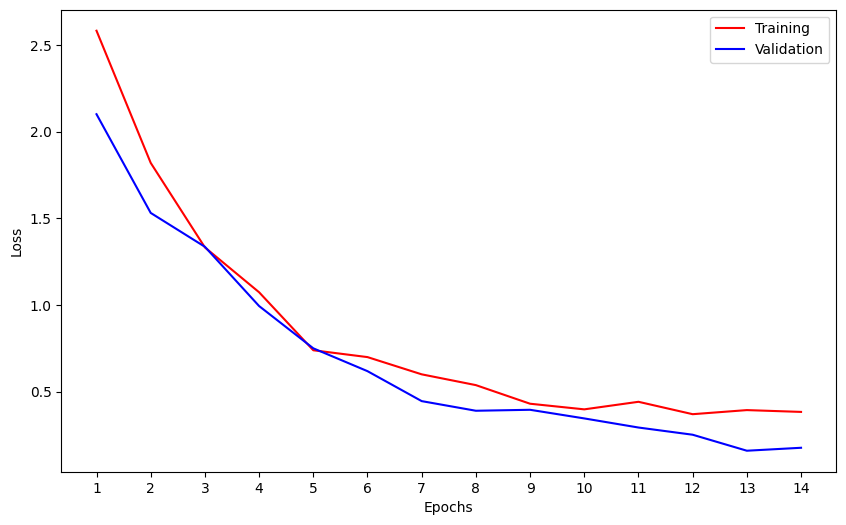

In [ ]:
# plot the training and validation losses
epochs = range(1, len(loss)+1)

fig1 = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,validation_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()

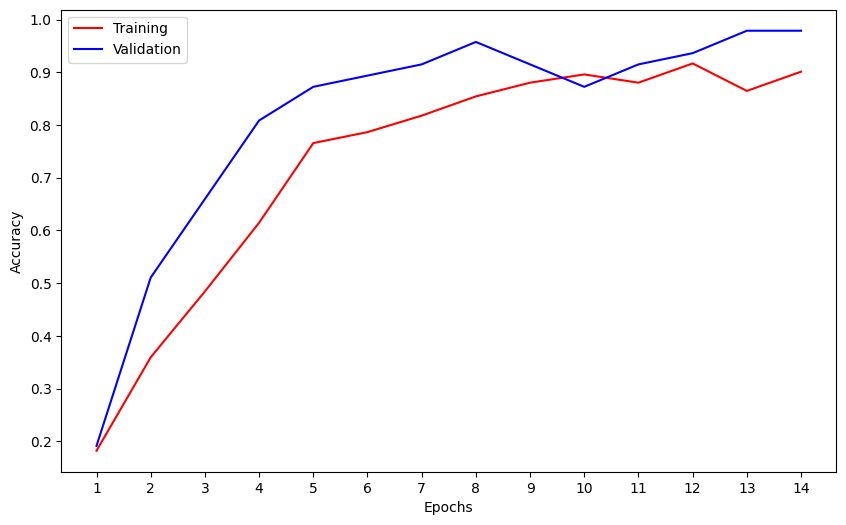

In [ ]:
# plot the training and validation accuracy
epochs = range(1, len(accuracy)+1)

fig2 = plt.figure(figsize=(10,6))
plt.plot(epochs,accuracy,c="red",label="Training")
plt.plot(epochs,validation_accuracy,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()

# 9. Confusion Matrix

In [ ]:
# sorting_indices = np.argsort(valid_batches.filenames)
pred = model.predict(test_batches)
y_pred = np.argmax(pred, axis=1)
y_pred

5/5 [==============================] - 10s 1s/step


array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 6, 2, 2, 2, 3, 3, 3, 7, 1, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 2, 6, 6, 6, 7, 7, 7, 7, 7])

In [ ]:
y_true = test_batches.labels
y_true

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7], dtype=int32)

Confusion Matrix:
[[5 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0]
 [0 0 4 0 0 0 1 0]
 [0 1 0 3 0 0 0 1]
 [0 0 0 0 5 0 0 0]
 [0 0 0 0 0 5 0 0]
 [0 0 1 0 0 0 4 0]
 [0 0 0 0 0 0 0 5]]


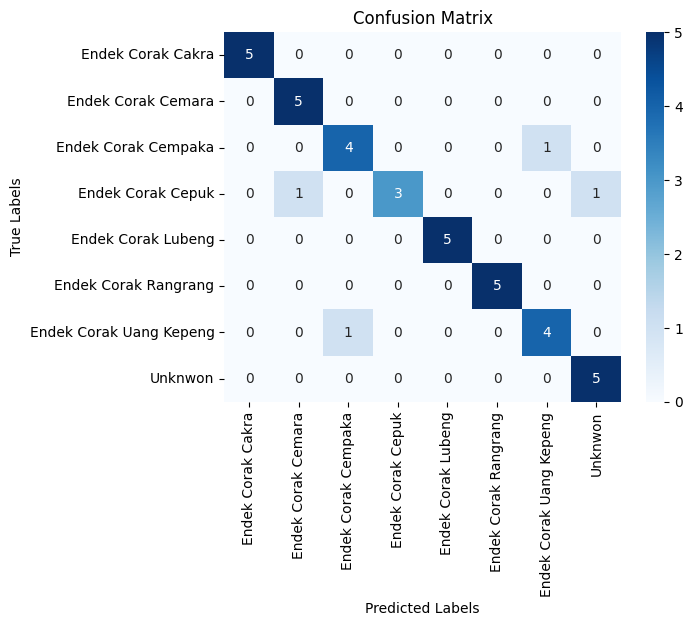

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('Confusion Matrix:')
print(cm)

# Visualize the confusion matrix as a heatmap
labels = ['Endek Corak Cakra',
          'Endek Corak Cemara',
          'Endek Corak Cempaka',
          'Endek Corak Cepuk',
          'Endek Corak Lubeng',
          'Endek Corak Rangrang',
          'Endek Corak Uang Kepeng',
          'Unknwon']
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       0.80      0.80      0.80         5
           3       1.00      0.60      0.75         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.80      0.80      0.80         5
           7       0.83      1.00      0.91         5

    accuracy                           0.90        40
   macro avg       0.91      0.90      0.90        40
weighted avg       0.91      0.90      0.90        40



# 10. Show Prediction

In [ ]:
test_image = load_img('/content/JPEG image 4.jpeg',
                            target_size = (224, 224))

test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(result)

FileNotFoundError: ignored

In [ ]:
train_batches.class_indices

In [ ]:
classes=['Endek Corak Cakra', 'Endek Corak Cemara', 'Endek Corak Cempaka',
        'Endek Corak Cepuk', 'Endek Corak Lubeng', 'Endek Corak Uang Kepeng']

prediction = result
#return position of max
MaxPosition=np.argmax(prediction)
prediction_label=classes[MaxPosition]
print(prediction_label)

# 11. Export The Model


In [ ]:
model.save('image_class_beta.h5')

In [ ]:
model = tf.keras.models.load_model('/content/image_class_beta.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("my_model.tflite", "wb").write(tflite_model)

In [ ]:
import shutil

shutil.rmtree('/content/compostnet-dataset-resized/trash')